# Kaggle Competiton | Telstra Network Disruptions

>We need to build a model to efficiently predict Telstra network's fault severity at a time at a particular location based on the log data available. The log data is splited in several tables therefore we need first to aggregate the data in each table by time (id) and location and merge tables.

>In order to build this model we first need to learn from the data (train data) which features could lead to one decission or the other. We will set up a protocol for processing data and it will be implemented in a pipeline.

>Additionally, we will predict a model with this processed data using the Random Forest classifier and its default parameters. Finally, we will assess the sampling by performing Cross Validation and the predictions by plotting confusion matrices.

Go to the official page of the [Kaggle Competition.](https://www.kaggle.com/c/telstra-recruiting-network)

### Goal for this Notebook:
* Aggregate data by time (id) and location in each table
* Merge tables to collect all the features to learn from
* Explore whether or not there are missing values
* Explore how to preprocess the data 
* Explore sklearn classes and methods to process our data
* Develope new classes and methods (data_modifier.py) and evaluate them to process data
* Develope a protocol for processing data and include it into a pipeline
* Generate a train and a test sets out of the initial given train data
* Generate a model using processed data with Random Forest classifier and default parameters
* Apply 3-fold Cross Validation to train dataset and perform the predictions in each case
* Evaluate the models generated with a confussion matrix

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from scipy import stats
from clean import *

%matplotlib inline

/usr/local/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


### 1. Handle Data

* Load and clean the data

In [3]:
event = pd.read_csv("../../../github_data/telstradisr_data/event_type.csv")
log = pd.read_csv("../../../github_data/telstradisr_data/log_feature.csv")
sample = pd.read_csv("../../../github_data/telstradisr_data/sample_submission.csv")
severity = pd.read_csv("../../../github_data/telstradisr_data/severity_type.csv")
resource = pd.read_csv("../../../github_data/telstradisr_data/resource_type.csv")
train = pd.read_csv("../../../github_data/telstradisr_data/train.csv")
test = pd.read_csv("../../../github_data/telstradisr_data/test.csv")

In [4]:
event['event_type'] = event['event_type'].str.split(' ').str[1]
log['log_feature'] = log['log_feature'].str.split(' ').str[1]
severity['severity_type'] = severity['severity_type'].str.split(' ').str[1]
resource['resource_type'] = resource['resource_type'].str.split(' ').str[1]
test['location'] = test['location'].str.split(' ').str[1]
train['location'] = train['location'].str.split(' ').str[1]

* Each time/location entry is repeated in the log tables therefore we need to aggregate the values into a dictionary
* Count each of the times the value is repeated since checked that they are actually repeated
    - For each feature {value:count, value:count...}
    - In the cases of two features per table, two dataframes are created, each for each feature

In [5]:
tables = [log,event,severity,resource] 
names = ['log','event','severity','resource'] 
for i in range(len(tables)):
    check = unique_column(tables[i],tables[i].columns[-1])
    
    # AGGREGATE CATEGORICAL VALUES INTO A DICTIO
    if check == False:
        if len(tables[i].columns) == 2:
            a = tables[i].groupby([tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count'})
            a.index.names = ['id','cat']
            a = a.reset_index()
            a = a.set_index('cat')
            
            # check if any value is greater than 1
            #l1 = a[tables[i].columns[-1]]
            #l3 = a[tables[i].columns[-2]]
            #for i in range(len(l1)):
            #    if l3.iloc[i] != 1:
            #        print('more than once',l3.iloc[i])
                    
            # take care that keys are still integers in the dict            
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            tables[i] = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            
        elif len(tables[i].columns) == 3:
            a = tables[i].groupby([tables[i].columns[-3],tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count',tables[i].columns[-2]:'count'})
            a.index.names = ['id','cat1','cat2']
            a = a.reset_index()
            a = a.set_index('cat1')
            b = a.set_index('cat2')
            
            # check if any value is greater than 1
            #l1 = a[tables[i].columns[-1]]
            #l2 = a[tables[i].columns[-3]]
            #l3 = a[tables[i].columns[-2]]
            #print(l1,l2,l3)
            #for i in range(len(l1)):
            #    if l1.iloc[i] != 1:
            #        print('more than once',l2.iloc[i])
            #for i in range(len(l3)):
            #    if l3.iloc[i] != 1:
            #        print('more than once',l2.iloc[i])
        
            # take care that keys are still integers in the dict
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            b = b.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-2]].items()})
            log1 = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            log2 = pd.DataFrame(b,columns=[tables[i].columns[-2]])
event = tables[1]
severity = tables[2]
resource = tables[3]

In [6]:
log1.head()

,volume
id,
1,"{345: 1, 179: 1, 68: 1}"
2,"{312: 1, 313: 1, 315: 1, 235: 1, 233: 1}"
3,{171: 1}
4,{370: 1}
5,"{232: 1, 312: 1}"


In [7]:
event.head()

,event_type
id,
1,"{11: 1, 13: 1}"
2,"{34: 1, 35: 1}"
3,{11: 1}
4,{47: 1}
5,"{34: 1, 35: 1}"


* Merge tables to generate train and test datasets with the same features

In [8]:
train = train.merge(event, left_on='id', right_index=True, how='left')
train = train.merge(severity, left_on='id', right_index=True, how='left')
train = train.merge(resource, left_on='id', right_index=True, how='left')
train = train.merge(log1, left_on='id', right_index=True, how='left')
train = train.merge(log2, left_on='id', right_index=True, how='left')
train.head()

,id,location,fault_severity,event_type,severity_type,resource_type,volume,log_feature
0,14121,118,1,"{34: 1, 35: 1}",{2: 1},{2: 1},"{232: 1, 312: 1}",{19: 1}
1,9320,91,0,"{34: 1, 35: 1}",{2: 1},{2: 1},"{315: 1, 235: 1}","{200: 1, 116: 1}"
2,14394,152,1,"{34: 1, 35: 1}",{2: 1},{2: 1},"{301: 1, 221: 1}",{1: 1}
3,8218,931,1,"{11: 1, 15: 1}",{1: 1},{8: 1},"{80: 1, 82: 1, 203: 1}","{1: 1, 12: 1, 9: 1}"
4,14804,120,0,"{36: 1, 34: 1, 11: 1, 20: 1}",{1: 1},"{8: 1, 2: 1}","{160: 1, 181: 1, 227: 1, 117: 1, 134: 1, 232: ...","{1: 1, 2: 1}"


In [9]:
test = test.merge(event, left_on='id', right_index=True, how='left')
test = test.merge(severity, left_on='id', right_index=True, how='left')
test = test.merge(resource, left_on='id', right_index=True, how='left')
test = test.merge(log1, left_on='id', right_index=True, how='left')
test = test.merge(log2, left_on='id', right_index=True, how='left')
test.head()

,id,location,event_type,severity_type,resource_type,volume,log_feature
0,11066,481,"{34: 1, 35: 1}",{2: 1},{2: 1},"{308: 1, 228: 1, 310: 1, 230: 1}","{24: 1, 20: 1, 26: 1, 28: 1}"
1,18000,962,"{11: 1, 15: 1}",{1: 1},{8: 1},"{82: 1, 203: 1}","{9: 1, 20: 1}"
2,16964,491,"{34: 1, 35: 1}",{2: 1},{2: 1},"{315: 1, 235: 1}","{10: 1, 11: 1}"
3,4795,532,"{10: 1, 27: 1}",{5: 1},"{9: 1, 3: 1}","{240: 1, 37: 1, 38: 1}",{1: 1}
4,3392,600,{15: 1},{2: 1},{8: 1},"{82: 1, 203: 1}","{2: 1, 6: 1}"


* Use train data to generate train and test datasets and evaluate the data

In [10]:
tr_a, te_a = train_test_split(train, train_size = 0.8)
y_train = tr_a.fault_severity
y_test = te_a.fault_severity
columns = train.columns
x_train = tr_a[columns[3:]]
x_test = te_a[columns[3:]]

In [11]:
## check if null values
tr_a.isnull().sum()
te_a.isnull().sum()
test.isnull().sum()

id               0
location         0
event_type       0
severity_type    0
resource_type    0
volume           0
log_feature      0
dtype: int64

In [12]:
## check if nan values
nantr = ifNaN(x_train)
nante = ifNaN(x_test)
print(nantr,nante)

False False


In [13]:
x_train.head()

,event_type,severity_type,resource_type,volume,log_feature
642,{11: 1},{2: 1},{8: 1},"{160: 1, 44: 1}",{1: 1}
6340,"{34: 1, 35: 1}",{2: 1},{2: 1},"{232: 1, 312: 1}","{20: 1, 28: 1}"
942,"{11: 1, 15: 1}",{1: 1},{8: 1},"{193: 1, 82: 1, 203: 1, 71: 1}","{1: 1, 2: 1, 12: 1, 20: 1}"
5296,"{34: 1, 35: 1}",{2: 1},{2: 1},"{232: 1, 312: 1}","{1: 1, 2: 1}"
5720,"{34: 1, 35: 1}",{2: 1},{2: 1},"{232: 1, 233: 1, 313: 1, 312: 1}","{1: 1, 116: 1, 65: 1}"


In [14]:
x_test.head()

,event_type,severity_type,resource_type,volume,log_feature
4924,{11: 1},{1: 1},{8: 1},{87: 1},{3: 1}
4335,"{34: 1, 35: 1}",{2: 1},{2: 1},"{233: 1, 315: 1, 313: 1}",{1: 1}
823,{35: 1},{4: 1},{2: 1},"{313: 1, 315: 1}",{1: 1}
5752,{11: 1},{1: 1},{8: 1},"{171: 1, 55: 1}",{2: 1}
2726,"{34: 1, 35: 1}",{2: 1},{2: 1},"{232: 1, 307: 1, 227: 1, 312: 1, 233: 1, 235: ...","{20: 1, 5: 1, 6: 1, 7: 1, 10: 1, 15: 1}"


In [15]:
x_train.shape

(5904, 5)

### 2. Analyze Data
* Generate a pipeline using DictVectorizer from Sklearn
* Apply for each column and generate one feature per category in each column
* Generate a quick and dirty first prediction using Random Forest classifier with default parameters

In [16]:
call = PipelineTelstra(RandomForestClassifier)
call.set_params()
call = call.fit(x_train,y_train)

pipeline done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.
DataSpliterTrans fit done.
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

In [17]:
y_predict = call.predict(x_test)

DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.
DataSpliterTrans transform done.


### 3. Evaluate model
* Evaluate the prediction by creating a confussion matrix
* Plot by a heatmap

In [18]:
cm1 = confusion_matrix(y_test,y_predict)
cm1

array([[819, 110,  25],
       [176, 183,  30],
       [ 29,  42,  63]])

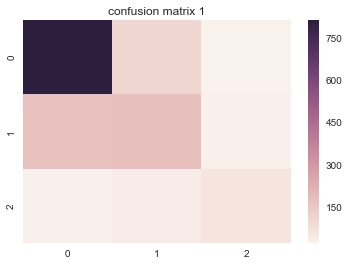

In [19]:
ax = sns.heatmap(cm1)
ax.set_title('confusion matrix 1')

In [ ]:
fig = ax.get_figure()
fig.savefig("cm1_preCV.png")

* Evaluate the predictions with 3-Fold Cross Validation

In [ ]:
x_train.shape

In [ ]:
kf = KFold(5904, n_folds=3)
itr = defaultdict(list)
ite = defaultdict(list)
c = 0
for trai, tes in kf:
    print("%s %s" % (trai, tes))
    itr[c] = trai
    ite[c] = tes
    c += 1

#### 3.1. Data Set 1
* Select the data
* Perform the prediction
* Plot the results in a confusion matrix

In [ ]:
x_train1 = x_train.iloc[itr[0],:]
x_test1 = x_train.iloc[ite[0],:]
y_train1 = tr_a.fault_severity.iloc[itr[0]]
y_test1 = tr_a.fault_severity.iloc[ite[0]]

In [ ]:
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(x_train1,y_train1)

In [ ]:
y_predict1 = call.predict(x_test1)

In [ ]:
cm21 = confusion_matrix(y_test1,y_predict1)
cm21

In [ ]:
ax = sns.heatmap(cm21)
ax.set_title('confusion matrix 2.1')

In [ ]:
fig = ax.get_figure()
fig.savefig("cm21_posCV.png")

#### 3.2. Data Set 2 
* Select the data
* Perform the prediction
* Plot the results in a confusion matrix

In [ ]:
x_train2 = x_train.iloc[itr[1],:]
x_test2 = x_train.iloc[ite[1],:]
y_train2 = tr_a.fault_severity.iloc[itr[1]]
y_test2 = tr_a.fault_severity.iloc[ite[1]]

In [ ]:
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(x_train2,y_train2)

In [ ]:
y_predict2 = call.predict(x_test2)

In [ ]:
cm22 = confusion_matrix(y_test2,y_predict2)
cm22

In [ ]:
ax = sns.heatmap(cm22)
ax.set_title('confusion matrix 2.2')

In [ ]:
fig = ax.get_figure()
fig.savefig("cm22_posCV.png")

#### 3.3. Data Set 3 
* Select the data
* Perform the prediction
* Plot the results in a confusion matrix

In [ ]:
x_train3 = x_train.iloc[itr[2],:]
x_test3 = x_train.iloc[ite[2],:]
y_train3 = tr_a.fault_severity.iloc[itr[2]]
y_test3 = tr_a.fault_severity.iloc[ite[2]]

In [ ]:
call = PipelineTelstra(RandomForestClassifier)
call = call.fit(x_train3,y_train3)

In [ ]:
y_predict3 = call.predict(x_test3)

In [ ]:
cm23 = confusion_matrix(y_test3,y_predict3)
cm23

In [ ]:
ax = sns.heatmap(cm23)
ax.set_title('confusion matrix 2.3')

In [ ]:
fig = ax.get_figure()
fig.savefig("cm23_posCV.png")

The confusion matrices display a good sampling. 

In the next notebook (gs_score.ipynb) parameters from Random Forest classifier will be evaluated through Grid Search.